# Title: Evaluating the Use of Rule-Based CIELAB Analysis in Undertone Skin Detection


### Objective

The objective of this experiment is to evaluate the effectiveness of a **rule-based approach using CIELAB color space** in detecting **skin undertones** from facial images. Specifically, we aim to determine whether CIELAB values—derived from dominant skin colors extracted via HSV-based masking—are sufficient to classify undertones (cool, warm, neutral) through predefined thresholds.

This experiment serves as a preliminary investigation that supports the need for more robust solutions like our proposed CNN-based system for undertone detection in our thesis work.

---

### Method

We applied a **rule-based classification system** using the a\* and b\* components of the CIELAB color space, which are known to represent chromaticity (red-green and yellow-blue axes, respectively). These values were extracted from dominant RGB skin tones using **OpenCV HSV masking** and the **ColorThief** library.

The classification rules were based on prior studies (e.g., Kaur et al., 2018; Mima et al., 2025) and defined as follows:
- `a* > 15 and b* < 10` → **Cool**
- `b* > 15 and a* < 10` → **Warm**
- `10 ≤ a*, b* ≤ 15` → **Neutral**
- All other values → **Unclassified**

Performance was evaluated by comparing predicted undertones to manually labeled ground truth data.

### Imports and Setup

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from colorthief import ColorThief
from skimage import color
from sklearn.metrics import (
    confusion_matrix,
    precision_recall_fscore_support,
    accuracy_score
)

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

### Load Labels
Ground-truth undertone labels are pre-labeled in a CSV file.

In [4]:
# Load and normalize labels
labels_df = pd.read_csv("undertone_labels.csv")
labels_df["ground_truth_undertone"] = labels_df["ground_truth_undertone"].str.strip().str.lower()

### Sample Image: HSV Skin Masking

To illustrate how the existing skin tone system isolates skin color, we show below the result of applying OpenCV’s HSV mask to one of our sample images (`img1.jpg`).

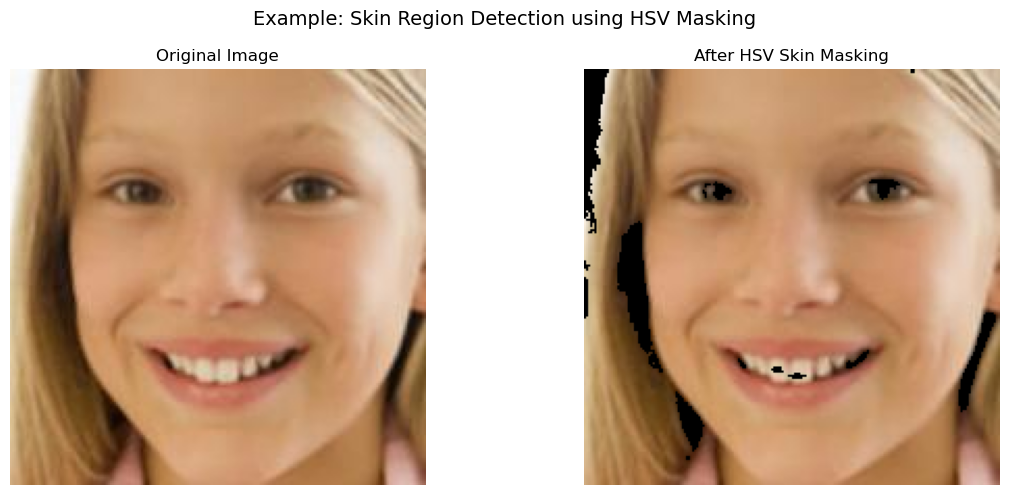

In [5]:
import cv2
import matplotlib.pyplot as plt

# Load your sample image
img_path = "images/img1.jpg"  # make sure this path is correct
image = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Apply HSV skin mask
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
lower_skin = (0, 20, 70)
upper_skin = (20, 255, 255)
mask = cv2.inRange(hsv, lower_skin, upper_skin)
masked = cv2.bitwise_and(image_rgb, image_rgb, mask=mask)

# Plot original vs masked
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(masked)
plt.title("After HSV Skin Masking")
plt.axis('off')

plt.suptitle("Example: Skin Region Detection using HSV Masking", fontsize=14)
plt.tight_layout()
plt.show()

### Image Processing and Rule-Based Undertone Prediction
This section simulates a basic tone-detection system by using OpenCV’s HSV skin mask + ColorThief dominant color.
We then classify undertone using:

- `a* > 15 and b* < 20` → **Cool**
- `b* > 20 and a* < 15` → **Warm**
- `10 ≤ a* ≤ 20 and 15 ≤ b* ≤ 25` → **Neutral**

In [41]:
actuals = []
predictions = []
lab_points = []

for index, row in labels_df.iterrows():
    img_name = row["image_name"]
    true_label = row["ground_truth_undertone"]
    img_path = os.path.join("images", img_name)

    image = cv2.imread(img_path)
    if image is None:
        continue

    # Skin segmentation using HSV
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_skin = (0, 20, 70)
    upper_skin = (20, 255, 255)
    mask = cv2.inRange(image_hsv, lower_skin, upper_skin)
    skin = cv2.bitwise_and(image, image, mask=mask)

    # Save temporary image
    temp_path = "temp.jpg"
    cv2.imwrite(temp_path, skin)

    try:
        color_thief = ColorThief(temp_path)
        dominant_rgb = color_thief.get_color(quality=1)
    except:
        continue

    # Convert to CIELAB
    rgb_array = np.array(dominant_rgb) / 255.0
    lab = color.rgb2lab(rgb_array.reshape((1, 1, 3)))
    _, a, b = lab[0, 0]

    # Rule-based logic
    if a > 15 and b < 20:
        pred = "cool"
    elif b > 20 and a < 15:
        pred = "warm"
    elif 10 <= a <= 20 and 15 <= b <= 25:
        pred = "neutral"
    else:
        pred = "unclassified"



    actuals.append(true_label)
    predictions.append(pred)
    lab_points.append((a, b, true_label, pred))


### Class-Specific Confusion Matrices

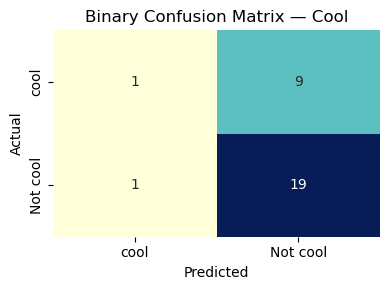

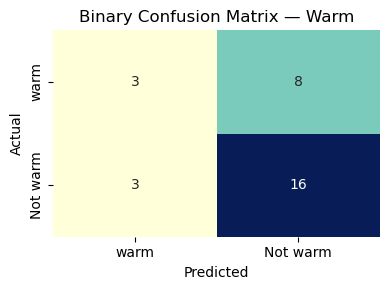

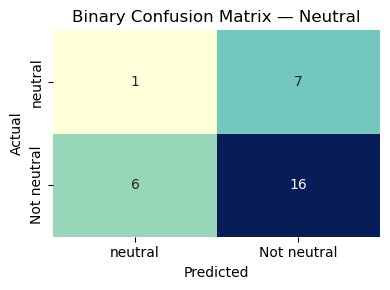

In [42]:
# Normalize predictions
actuals = [a.strip().lower() for a in actuals]
predictions = [p.strip().lower() for p in predictions]

labels = ["cool", "warm", "neutral"]

# Print class-wise confusion matrices
for target_class in labels:
    binary_actuals = [1 if label == target_class else 0 for label in actuals]
    binary_preds = [1 if label == target_class else 0 for label in predictions]

    if sum(binary_actuals) == 0 and sum(binary_preds) == 0:
        print(f"Skipping {target_class} — no data.")
        continue

    cm = confusion_matrix(binary_actuals, binary_preds, labels=[1, 0])

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", cbar=False,
                xticklabels=[f"{target_class}", f"Not {target_class}"],
                yticklabels=[f"{target_class}", f"Not {target_class}"])
    plt.title(f"Binary Confusion Matrix — {target_class.capitalize()}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

### Precision, Recall, and F1 Score per Undertone Class

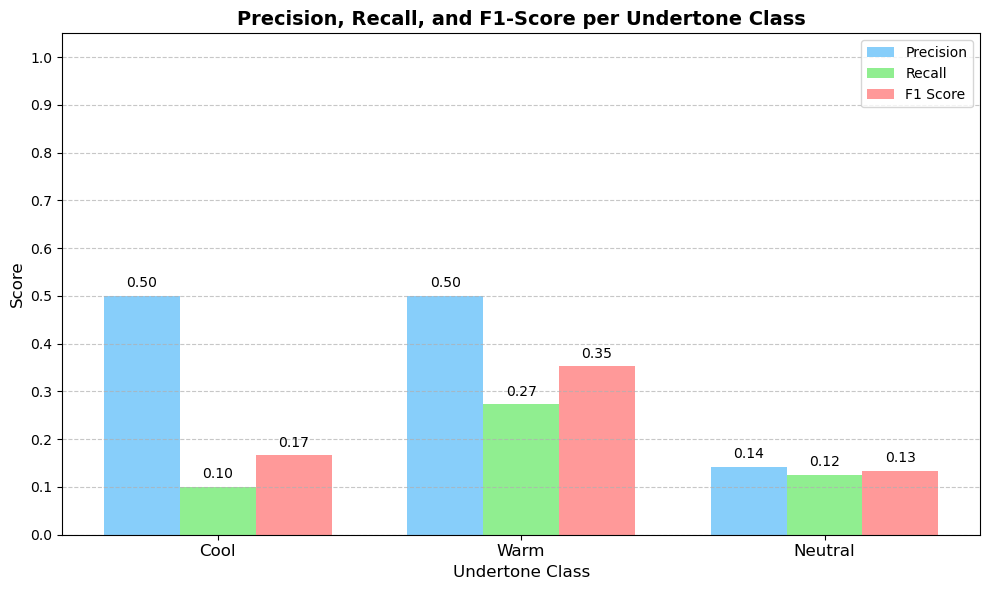


Overall Accuracy: 16.67%


In [43]:
precision, recall, f1, support = precision_recall_fscore_support(
    actuals, predictions, labels=labels, zero_division=0
)
accuracy = accuracy_score(actuals, predictions)

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(10, 6))
bar1 = plt.bar(x - width, precision, width=width, label='Precision', color='#87CEFA')
bar2 = plt.bar(x, recall, width=width, label='Recall', color='#90EE90')
bar3 = plt.bar(x + width, f1, width=width, label='F1 Score', color='#FF9999')

# Annotate bars
for bars in [bar1, bar2, bar3]:
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f"{height:.2f}",
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 4),
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=10)

plt.xticks(x, [l.capitalize() for l in labels], fontsize=12)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylim(0, 1.05)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Undertone Class", fontsize=12)
plt.title("Precision, Recall, and F1-Score per Undertone Class", fontsize=14, weight='bold')
plt.legend(loc="upper right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nOverall Accuracy:", f"{accuracy * 100:.2f}%")

In [ ]:

# Table: CIELAB a*, b*, True Label, Predicted Label
summary_df = pd.DataFrame(lab_points, columns=["a*", "b*", "True", "Predicted"])
summary_df["a*"] = summary_df["a*"].round(2)
summary_df["b*"] = summary_df["b*"].round(2)
summary_df.head(30)  # Show all data


,a*,b*,True,Predicted
0,13.30,27.83,warm,warm
1,6.43,11.48,cool,unclassified
2,16.30,15.07,neutral,cool
3,10.64,13.36,neutral,unclassified
4,13.44,17.72,warm,neutral
5,-0.00,0.00,cool,unclassified
6,13.56,25.55,warm,warm
7,18.60,29.65,warm,unclassified
8,11.00,22.79,neutral,warm
9,3.24,3.81,neutral,unclassified


### Final Conclusion

This experiment evaluated whether existing skin tone detection techniques—specifically HSV-based skin masking combined with dominant color extraction using the ColorThief library—can accurately classify **skin undertones** based on CIELAB color values.

Using a rule-based classification schema derived from prior literature and color theory (Lagouvardo et al., 2018), undertones were labeled as **cool**, **warm**, or **neutral** depending on the relationship between the chromatic channels a* and b*. The system’s predictions were tested against pre-labeled ground truth data for a subset of images.

---

#### Experimental Findings

- The system achieved an **overall accuracy of 16.67%** (5 correct out of 30 samples), despite using perceptually grounded classification rules.
- Most predictions were either **misclassified** or **returned as “unclassified”**, particularly when chromatic values were near threshold boundaries or when masking failed.
- **Examples:**
  - `a* = 13.30, b* = 27.83` → **Ground Truth: Warm** → ✅ Predicted: Warm  
  - `a* = 6.43, b* = 11.48` → **Ground Truth: Cool** → ❌ Predicted: Unclassified  
  - `a* = 13.21, b* = 16.18` → **Ground Truth: Cool** → ❌ Predicted: Neutral
- In some cases, values like `a* = 0, b* = 0` were extracted due to HSV masking failure, highlighting how lighting and extraction errors can undermine accuracy.

These results demonstrate that while the rule-based method offers interpretability and is grounded in theory, it lacks robustness in real-world conditions. It fails to account for facial color distribution, lighting variance, and subtle undertone cues that are not captured by a single dominant color value.

---

#### Limitations of the Existing System

- **HSV-based skin masking** is highly sensitive to lighting, often excluding or misidentifying skin regions.
- **ColorThief's dominant color extraction** reduces complex skin tone variation to a single RGB value, ignoring the spatial distribution critical to undertone perception.
- The **rule-based classification** fails for borderline cases and relies heavily on strict thresholds that do not generalize across diverse skin tones.
- The system offers **limited interpretability** when no undertone is predicted or when output is “unclassified.”

---

#### How Our Thesis Addresses These Issues

The proposed thesis system—**A Facial Image-Based CNN and CIELAB System for Skin Tone and Undertone Detection**—is designed to overcome these limitations through a more robust and perceptually accurate approach:

- It utilizes the **entire facial image**, capturing holistic chromatic and spatial patterns instead of relying on one dominant skin pixel.
- A **Convolutional Neural Network (CNN)** is trained to learn complex undertone-relevant features from a broader data distribution.
- The system incorporates **CIELAB-based analysis** for interpretability, while using expert-labeled data for model validation.
- It is developed with an emphasis on inclusivity, particularly tailored to **Filipino skin tones** under real-world lighting and device conditions.

---

#### Conclusion

The limited performance of the rule-based classification system, even when informed by literature, reinforces the need for a more adaptive and data-driven method of undertone detection. Our proposed deep learning-based system is better suited to address the inherent complexity and subjectivity of skin undertones, particularly in applications such as personalized cosmetics and inclusive beauty technology.